In [68]:
# import statments
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

In [69]:
#global variables
renamed_stocks = {"FB": "META"}
failed_downloads = []
cutoff_date = pd.to_datetime('2016-12-01')

#Clean dataframe
df = pd.read_csv("congress_trades.csv")

df["ReportDate"] = pd.to_datetime(df["ReportDate"])
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

df = df.loc[df["TransactionDate"] > cutoff_date]
df.loc[~df["Transaction"].str.contains("Purchase"), "Amount"] = - df["Amount"]
df["Ticker"] = df["Ticker"].replace(renamed_stocks)

df.sort_values("TransactionDate", ascending=True, inplace=True)

In [70]:
#partition dataframe
portfolio = df.loc[(df["Representative"] == "Nancy Pelosi")]
portfolio.head(3)

,Representative,ReportDate,TransactionDate,Ticker,Transaction,Range,House,Amount,Party,last_modified
35009,Nancy Pelosi,2017-02-14,2017-01-19,AAPL,Purchase,"$500,001 - $1,000,000",Representatives,500001.0,D,2023-11-16
34993,Nancy Pelosi,2017-02-14,2017-01-20,AAPL,Sale,"$250,001 - $500,000",Representatives,-250001.0,D,2023-11-16
35004,Nancy Pelosi,2017-02-14,2017-01-20,SQ,Purchase,"$15,001 - $50,000",Representatives,15001.0,D,2023-11-16


In [71]:
#Download and store SPY stock data
end_date = datetime.today().strftime('%Y-%m-%d')
stock_data = yf.download("SPY", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False) #maybe use back_adjust=True? dunno
stock_data["Ticker"] = "SPY"
stock_data = stock_data[["Ticker", "Close"]]
stock_data

,Ticker,Close
Date,,
2016-12-01,SPY,192.43
2016-12-02,SPY,192.52
2016-12-05,SPY,193.68
2016-12-06,SPY,194.29
2016-12-07,SPY,196.84
...,...,...
2024-08-30,SPY,563.68
2024-09-03,SPY,552.08
2024-09-04,SPY,550.95


In [72]:
#Download and store AAPL and DIS stock data
tickers = portfolio["Ticker"].unique().tolist()
stocks = yf.download(tickers, start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False)
stocks_close = stocks['Close']
formatted_stocks = stocks_close.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='Close')
formatted_stocks = formatted_stocks.dropna(subset=['Close'])
formatted_stocks.set_index("Date", inplace=True)
stock_data = pd.concat([stock_data, formatted_stocks])
stock_data = stock_data.sort_values(by=['Ticker', 'Date'])
stock_data["DailyROI"] = stock_data.groupby('Ticker')['Close'].pct_change().fillna(0) + 1.0
stock_data


2 Failed downloads:
['WORK', 'MONTGOMERY, AL .2, SCHAUMBERG, IL .1']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


,Ticker,Close,DailyROI
Date,,,
2016-12-01,AAPL,25.38,1.000000
2016-12-02,AAPL,25.47,1.003546
2016-12-05,AAPL,25.29,0.992933
2016-12-06,AAPL,25.48,1.007513
2016-12-07,AAPL,25.73,1.009812
...,...,...,...
2024-08-30,WBD,7.84,1.014230
2024-09-03,WBD,7.36,0.938776
2024-09-04,WBD,7.32,0.994565


In [73]:
#reset index for merging
stock_data.reset_index(inplace=True)

In [74]:
#add price and stock amount data for each transaction
portfolio = portfolio.merge(stock_data, how='left', left_on=['TransactionDate', 'Ticker'], right_on=['Date', 'Ticker'])
portfolio.drop(columns=['Date', "DailyROI"], inplace=True)
portfolio["StockAmount"] = portfolio["Amount"]/portfolio["Close"]
portfolio.head()

,Representative,ReportDate,TransactionDate,Ticker,Transaction,Range,House,Amount,Party,last_modified,Close,StockAmount
0,Nancy Pelosi,2017-02-14,2017-01-19,AAPL,Purchase,"$500,001 - $1,000,000",Representatives,500001.0,D,2023-11-16,27.76,18011.563401
1,Nancy Pelosi,2017-02-14,2017-01-20,AAPL,Sale,"$250,001 - $500,000",Representatives,-250001.0,D,2023-11-16,27.81,-8989.608055
2,Nancy Pelosi,2017-02-14,2017-01-20,SQ,Purchase,"$15,001 - $50,000",Representatives,15001.0,D,2023-11-16,14.89,1007.454668
3,Nancy Pelosi,2017-07-20,2017-06-15,AAPL,Purchase,"$500,001 - $1,000,000",Representatives,500001.0,D,2023-11-16,33.73,14823.628817
4,Nancy Pelosi,2017-07-20,2017-06-20,BFET,Sale,"$1,001 - $15,000",Representatives,-1001.0,D,2023-11-16,1.20,-834.166667


In [87]:
def holdings(trades, groupby_column = "TransactionDate"):
    dates = yf.download("AAPL", start=cutoff_date, progress=False).index.strftime("%Y-%m-%d")
    dates = pd.to_datetime(dates)

    cumulative_holdings = defaultdict(int)
    holdings_list = []

    trades_grouped = trades.groupby(groupby_column)

    for date in dates:
        if date in trades_grouped.groups:
            day_transactions = trades_grouped.get_group(date)

            # Efficiently update cumulative holdings
            for ticker, stock_amount in day_transactions.groupby('Ticker')['StockAmount'].sum().items():
                cumulative_holdings[ticker] += stock_amount
                if cumulative_holdings[ticker] <= 0:
                    del cumulative_holdings[ticker]

        # Append the current state of holdings to the list
        for ticker, stock_amount in cumulative_holdings.items():
            holdings_list.append({
                'Date': date,
                'Ticker': ticker,
                'StockAmount': stock_amount,
            })

    # Convert the holdings list to a DataFrame
    holdings_df = pd.DataFrame(holdings_list)

    return holdings_df 

In [76]:
myholdings = holdings(portfolio)
myholdings.to_csv("myholdings.csv")

In [77]:
myholdings = myholdings.merge(stock_data, left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'])
myholdings["StockValue"] = myholdings["StockAmount"] * myholdings["Close"]
myholdings

,Date,Ticker,StockAmount,Close,DailyROI,StockValue
0,2017-01-19,AAPL,18011.563401,27.76,0.998202,5.000010e+05
1,2017-01-20,AAPL,9021.955346,27.81,1.001801,2.509006e+05
2,2017-01-20,SQ,1007.454668,14.89,1.010862,1.500100e+04
3,2017-01-23,AAPL,9021.955346,27.83,1.000719,2.510810e+05
4,2017-01-23,SQ,1007.454668,14.61,0.981195,1.471891e+04
...,...,...,...,...,...,...
21746,2024-09-06,NVDA,112884.631766,102.83,0.959146,1.160793e+07
21747,2024-09-06,GOOG,13166.247099,152.13,0.959206,2.002981e+06
21748,2024-09-06,MU,2517.936629,86.38,0.966327,2.174994e+05
21749,2024-09-06,AAPL,12425.606118,220.82,0.992985,2.743822e+06


In [78]:
# Calculate total value for each date
myholdings['TotalValue'] = myholdings.groupby('Date')['StockValue'].transform('sum')

# Calculate weighted ROI
myholdings['WeightedROI'] = myholdings['StockValue'] / myholdings['TotalValue'] * myholdings['DailyROI']

# Calculate portfolio ROI
dates = yf.download("AAPL", start=cutoff_date, progress=False).index.strftime("%Y-%m-%d")
dates = pd.to_datetime(dates)
portfolio_roi = pd.DataFrame({'Date': dates})

portfolio_roi = portfolio_roi.merge(myholdings.groupby('Date')['WeightedROI'].sum().reset_index(), on="Date", how="left")
portfolio_roi.columns = ['Date', 'PortfolioROI']  # Rename the merged column
portfolio_roi['PortfolioROI'] = portfolio_roi['PortfolioROI'].fillna(1.0)

portfolio_roi["CumulativeROI"] = portfolio_roi["PortfolioROI"].cumprod()


In [85]:
portfolio_roi

,Date,PortfolioROI,CumulativeROI
0,2016-12-01,1.000000,1.000000
1,2016-12-02,1.000000,1.000000
2,2016-12-05,1.000000,1.000000
3,2016-12-06,1.000000,1.000000
4,2016-12-07,1.000000,1.000000
...,...,...,...
1949,2024-09-03,0.955239,9.332690
1950,2024-09-04,0.990942,9.248150
1951,2024-09-05,1.006910,9.312060
1952,2024-09-06,0.971204,9.043913


In [88]:
copytraded_holdings = holdings(portfolio, groupby_column="ReportDate")
copytraded_holdings = copytraded_holdings.merge(stock_data, left_on=['Date', 'Ticker'], right_on=['Date', 'Ticker'])
copytraded_holdings["StockValue"] = copytraded_holdings["StockAmount"] * copytraded_holdings["Close"]
copytraded_holdings['TotalValue'] = copytraded_holdings.groupby('Date')['StockValue'].transform('sum')
copytraded_holdings['CopyTradeROI'] = copytraded_holdings['StockValue'] / copytraded_holdings['TotalValue'] * copytraded_holdings['DailyROI']
portfolio_roi = portfolio_roi.merge(copytraded_holdings.groupby('Date')['CopyTradeROI'].sum().reset_index(), on="Date", how="left")

portfolio_roi['CopyTradeROI'] = portfolio_roi['CopyTradeROI'].fillna(1.0)
portfolio_roi["CopyCumulativeROI"] = portfolio_roi["CopyTradeROI"].cumprod()

In [94]:
holdings(portfolio, groupby_column="ReportDate").to_csv("copytraded_holdings.csv")

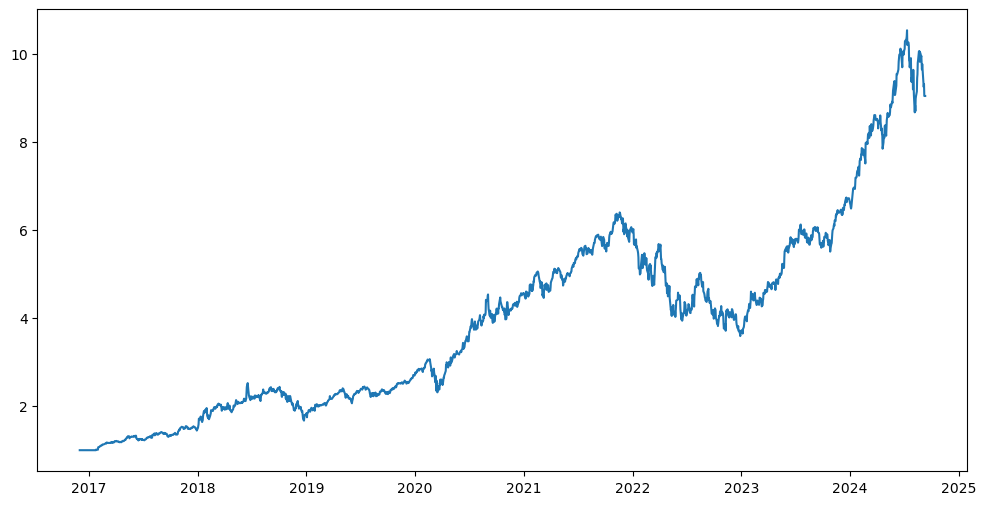

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_roi['Date'], portfolio_roi['CumulativeROI'])

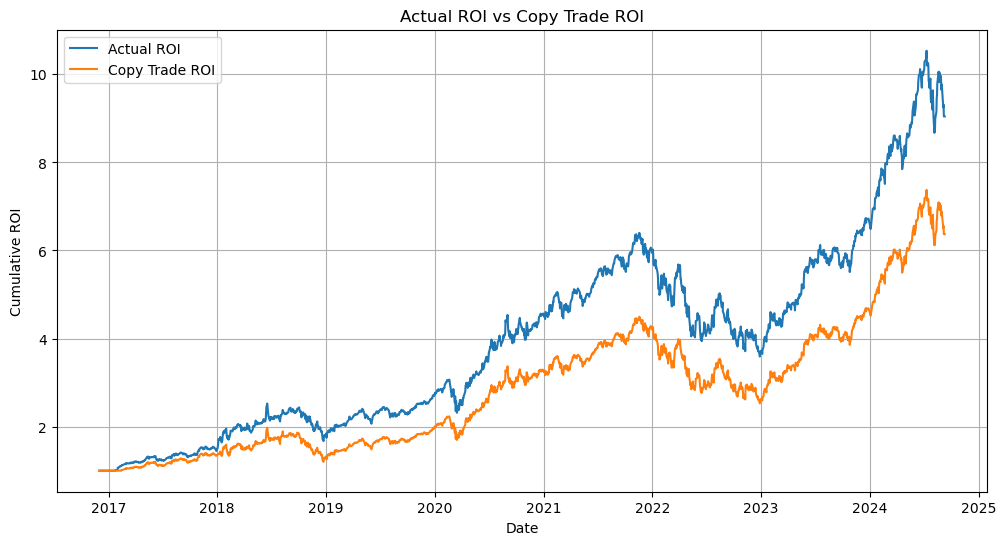

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_roi['Date'], portfolio_roi['CumulativeROI'], label='Actual ROI')
plt.plot(portfolio_roi['Date'], portfolio_roi['CopyCumulativeROI'], label='Copy Trade ROI')
plt.xlabel('Date')
plt.ylabel('Cumulative ROI')
plt.title('Actual ROI vs Copy Trade ROI')
plt.legend()
plt.grid(True)
plt.show()

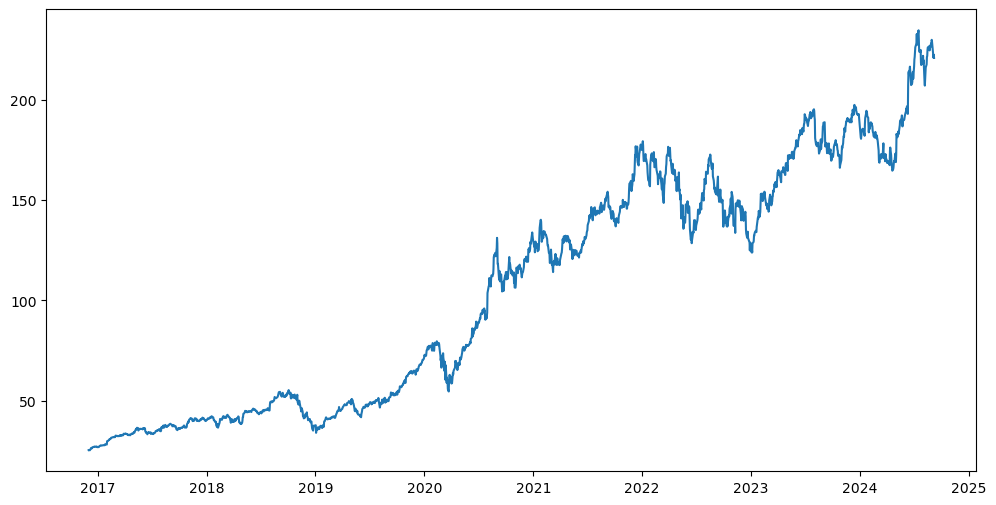

In [80]:
aapl_data = yf.download("AAPL", start=cutoff_date, end=end_date, auto_adjust=True, rounding=True, progress=False)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(aapl_data.index, aapl_data['Close'])